
## Task 2: Processing di segnali bi-dimensionali

In [ ]:
import os
import math
import random
import shutil
from skimage import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
!unzip '/content/gdrive/MyDrive/Magistrale/Secondo Anno/Progetto DSIM/Img.zip' -d '/content/' &> /dev/null

In [ ]:
BASE_DIR='/content/Img/'

In [ ]:
names = ["Alberto", "Alice", "Davide"]

In [ ]:
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)
        os.makedirs(BASE_DIR + 'extra/' + name)

Le immagini qui importate sono state scattate in università, così da avere condizioni di luminosità e sfondo simile tra i 3 componenti ma dissimile tra le foto.

In [ ]:
orig_folders = ["Alberto/", "Alice/", "Davide/"]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images * 0.75) + 0.5)
    n_valid = int((number_of_images * 0.10) + 0.5)
    n_test = number_of_images - n_train - n_valid

    print(folder, number_of_images, n_train, n_valid, n_test)

    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.copy2(file_name, BASE_DIR + "train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.copy2(file_name, BASE_DIR + "val/" + names[folder_idx])
        else:
            shutil.copy2(file_name, BASE_DIR + "test/" + names[folder_idx])

Alberto/ 1376 1032 138 206
Alice/ 1389 1042 139 208
Davide/ 1373 1030 137 206


Vengono ora inserite foto aggiuntive, scattate autonomamente dai 3 componenti del gruppo con condizione di illuminazione diversa e in luoghi differenti.

In [ ]:
NEW='/content/gdrive/MyDrive/Magistrale/Secondo Anno/Progetto DSIM/Foto nuove test/'

orig_folders = ["Alberto/", "Alice/", "Davide/"]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(NEW + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images * 0.75) + 0.5)
    n_valid = int((number_of_images * 0.10) + 0.5)
    n_test = number_of_images - n_train - n_valid

    print(folder, number_of_images, n_train, n_valid, n_test)

    for idx, file in enumerate(files):
        file_name = NEW + folder + file
        if idx < n_train:
            shutil.copy2(file_name, BASE_DIR + "train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.copy2(file_name, BASE_DIR + "val/" + names[folder_idx])
        else:
            shutil.copy2(file_name, BASE_DIR + "test/" + names[folder_idx])
            shutil.copy2(file_name, BASE_DIR + "extra/" + names[folder_idx])


Alberto/ 145 109 15 21
Alice/ 132 99 13 20
Davide/ 166 125 17 24


Alle immagini si applica il pre - processing specifico della rete pre-addestrara che è stata scelta (VGG16). All'interno del generator vengono già inseriti parametri di data augmentation, nello specifico: flip orizzontale, shift di altezza e luminosità, cambiamento della luminosità, zoom random e rotazione.

In [ ]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input
train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input,
                                     horizontal_flip=True,  
                                     width_shift_range=0.2,   
                                     height_shift_range=0.2,   
                                     brightness_range = (0.4,1.5), 
                                     zoom_range = [0.5,1.0],       
                                     rotation_range=90
                                     )

valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input,
                                     horizontal_flip=True, width_shift_range=0.2,    
                                     height_shift_range=0.2, brightness_range = (0.4,1.5),
                                     zoom_range = [0.5,1.0], rotation_range=90)

test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input,
                                     horizontal_flip=True, width_shift_range=0.2,    
                                     height_shift_range=0.2, brightness_range = (0.4,1.5), 
                                     zoom_range = [0.5,1.0], rotation_range=90)

In [ ]:
train_batches = train_gen.flow_from_directory(
    BASE_DIR+'train',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    color_mode="rgb",  
)

val_batches = valid_gen.flow_from_directory(
    BASE_DIR+'val',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    color_mode="rgb",
)

test_batches = test_gen.flow_from_directory(
    BASE_DIR+'test',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    color_mode="rgb",
)

extra_batch = test_gen.flow_from_directory(
    BASE_DIR+'extra',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    color_mode="rgb",
)

Found 3437 images belonging to 3 classes.
Found 458 images belonging to 3 classes.
Found 685 images belonging to 3 classes.
Found 65 images belonging to 3 classes.


In [ ]:
ytrain=train_batches.classes

In [ ]:
unique, counts = np.unique(ytrain, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 1141]
 [   1 1141]
 [   2 1155]]


La classificazione è bilanciata, il plot fa riferimento alle immagini presenti nel training set.

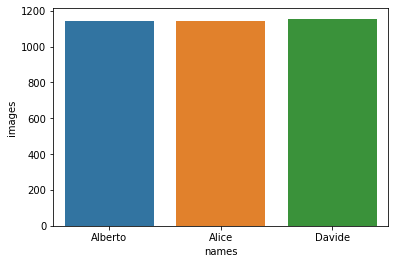

In [ ]:
df = pd.DataFrame({'names': names, 'images': counts})
fig = sn.barplot(x = 'names', y = 'images', data = df)

In [ ]:
alberto='/content/Img/train/Alberto/Alberto105.jpeg'
alice='/content/Img/train/Alice/Alice1113.jpeg'
davide='/content/Img/train/Davide/Davide1049.jpeg'

Nel dataset sono presenti foto in cui il volto ha espressioni differenti, non è frontale e altre volte risulta parzialmente ostruito.

Text(0.5, 1.0, 'Davide')

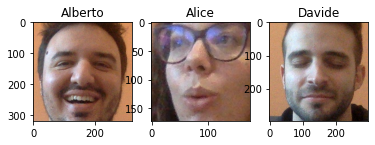

In [ ]:
plt.subplot(1,3,1); plt.imshow(io.imread(alberto)); plt.title("Alberto")
plt.subplot(1,3,2); plt.imshow(io.imread(alice)); plt.title("Alice")
plt.subplot(1,3,3); plt.imshow(io.imread(davide)); plt.title("Davide")

In [ ]:
alb2='/content/Img/train/Alberto/Alberto1091.jpeg'
ali2='/content/Img/train/Alice/Alice775.jpeg'
dav2='/content/Img/train/Davide/Davide1114.jpeg'

Text(0.5, 1.0, 'Davide')

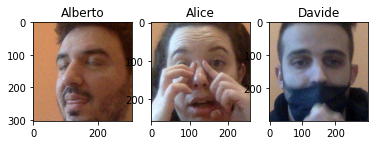

In [ ]:
plt.subplot(1,3,1); plt.imshow(io.imread(alb2)); plt.title("Alberto")
plt.subplot(1,3,2); plt.imshow(io.imread(ali2)); plt.title("Alice")
plt.subplot(1,3,3); plt.imshow(io.imread(dav2)); plt.title("Davide")

In [ ]:
base_model = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False, pooling='avg')
for layer in base_model.layers:
    layer.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


Alla struttura presa da VGG16 vengono aggiunti due layer densi con funzione di attivazione ReLu e il layer di output con funzione di attivazione Softmax.

In [ ]:
x = base_model.output
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(32, activation='relu')(x)
outputs = keras.layers.Dense(3, activation='softmax')(x)

In [ ]:
mod_1 = Model(inputs=base_model.input, outputs=outputs)
mod_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

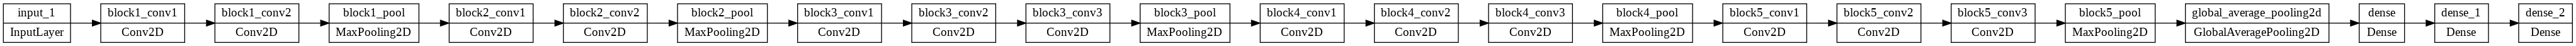

In [ ]:
keras.utils.plot_model(mod_1, rankdir='LR')

Viene utilizzato come ottimizzatore Adam con learning rate pari a 0.0005 e come funzione di loss la categotica crossentropy.

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0005)
mod_1.compile(loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy'])

Si allena il modello per 15 epoche con un batch size di 32

In [ ]:
hist = mod_1.fit(train_batches, epochs=15,validation_data=val_batches, 
                 batch_size=32)

Epoch 1/15
108/108 [==============================] - 103s 795ms/step - loss: 0.5789 - accuracy: 0.7931 - val_loss: 0.2335 - val_accuracy: 0.9105
Epoch 2/15
108/108 [==============================] - 59s 544ms/step - loss: 0.1791 - accuracy: 0.9427 - val_loss: 0.2056 - val_accuracy: 0.9301
Epoch 3/15
108/108 [==============================] - 54s 501ms/step - loss: 0.1175 - accuracy: 0.9601 - val_loss: 0.1044 - val_accuracy: 0.9629
Epoch 4/15
108/108 [==============================] - 56s 518ms/step - loss: 0.0868 - accuracy: 0.9683 - val_loss: 0.1023 - val_accuracy: 0.9629
Epoch 5/15
108/108 [==============================] - 54s 499ms/step - loss: 0.0821 - accuracy: 0.9709 - val_loss: 0.0634 - val_accuracy: 0.9738
Epoch 6/15
108/108 [==============================] - 55s 505ms/step - loss: 0.0713 - accuracy: 0.9727 - val_loss: 0.0696 - val_accuracy: 0.9782
Epoch 7/15
108/108 [==============================] - 54s 499ms/step - loss: 0.0561 - accuracy: 0.9817 - val_loss: 0.1027 - val_a

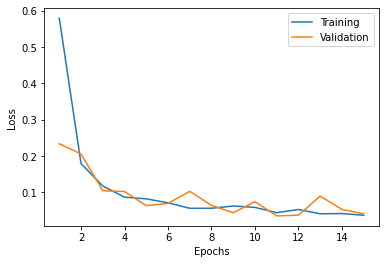

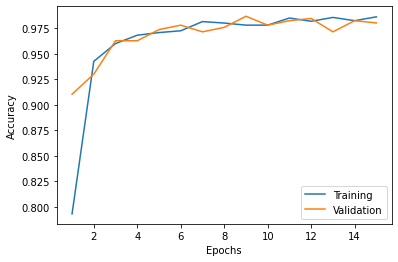

In [ ]:
n_epochs=15
x_plot = list(range(1,n_epochs+1))
def plot_history(network_history): 
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(hist)

In [ ]:
score=mod_1.evaluate(test_batches)
score

22/22 [==============================] - 10s 433ms/step - loss: 0.0618 - accuracy: 0.9869


[0.061764687299728394, 0.9868612885475159]

In [ ]:
y_pred=mod_1.predict(test_batches)
y_pred=np.argmax(y_pred,axis=1)
y_test=test_batches.labels

Classification report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       227
           1       1.00      0.98      0.99       228
           2       0.99      0.99      0.99       230

    accuracy                           0.99       685
   macro avg       0.99      0.99      0.99       685
weighted avg       0.99      0.99      0.99       685

Confusion matrix:
[[226   0   1]
 [  3 223   2]
 [  3   0 227]]


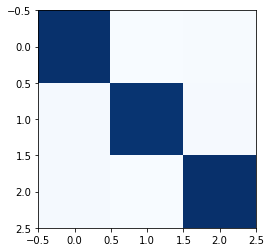

In [ ]:
print('Classification report:')
print(classification_report(y_test, y_pred))

print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

In [ ]:
y_pred_new=mod_1.predict(extra_batch)
y_pred=np.argmax(y_pred_new,axis=1)
y_test=extra_batch.labels

Classification report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       1.00      0.95      0.97        20
           2       0.96      0.96      0.96        24

    accuracy                           0.97        65
   macro avg       0.97      0.97      0.97        65
weighted avg       0.97      0.97      0.97        65

Confusion matrix:
[[21  0  0]
 [ 0 19  1]
 [ 1  0 23]]


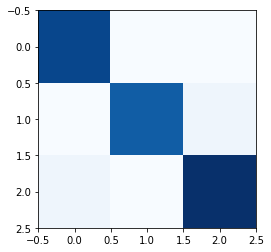

In [ ]:
# Classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

In [ ]:
mod_1.save('/content/gdrive/MyDrive/Magistrale/Secondo Anno/Progetto DSIM/mod_img.h5')